# Create final plots for Prelim-Proposal

This script creates plots which combine at least two different methods. The plots were used in the Prelim-Proposal.

In [23]:
# import useful packages
import obspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

## Plot Spectrogram & covariance eiganvalues

In [7]:
# read stacked stream for stream plot and specktrogram
st_stack = obspy.read("/Users/koepflma/Desktop/GIT/Mt-St-Helens/noise_analysis/test_stack.mseed")
tr = st_stack[0]

In [18]:
# calculate spectrogram
def calc_spec(tr, 
              NFFT,
              noverlap=0,         # overlap in samples
              detrend='linear',   # detrending before taking fourier transform
              mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
              scale_by_freq=True, # unit/Hz
              scale='dB',         # 'linear', 'dB'
              **kwargs):
    '''calculates a spectrogram from an obspy trace'''
    
    data = tr.data
    fs = tr.stats.sampling_rate #sampling rate
    Pxx, freqs, bins, _ = plt.specgram(data, 
                                    NFFT=NFFT, 
                                    Fs=fs, 
                                    noverlap=noverlap,
                                    detrend=detrend, 
                                    mode=mode,
                                    scale_by_freq=scale_by_freq,
                                    scale=scale,
                                    **kwargs)
    plt.close() # for execution in Jupyter Notebook/Lab
    return Pxx, freqs, bins, tr.stats

# Pxx, freqs, bins, stats = calc_spec(tr, NFFT=int(tr.stats.sampling_rate*180))#, NFFT=int(tr.stats.sampling_rate*600))
Pxx, freqs, bins, stats = calc_spec(tr, NFFT=int(tr.stats.sampling_rate*30))

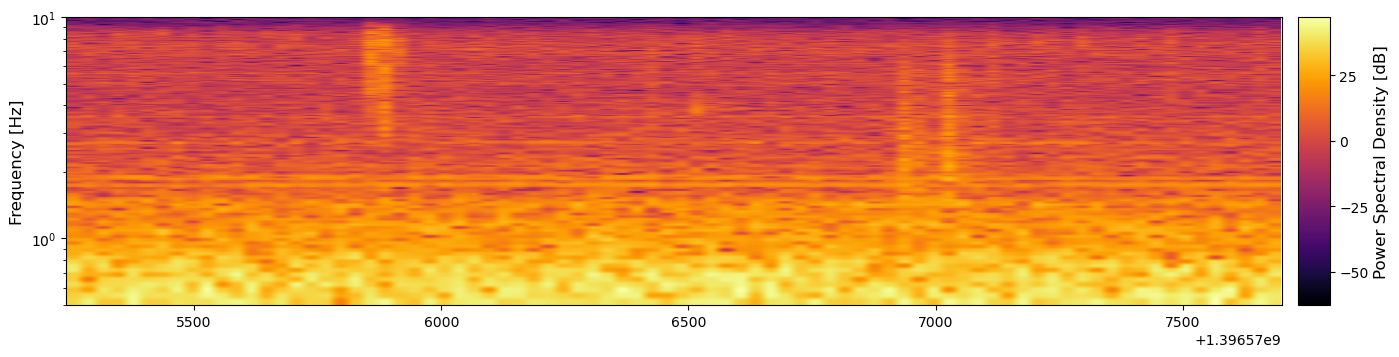

In [21]:
# plot the spectrogram
def plot_spectro(Pxx, freqs, bins, stats, 
                 t_int=False,
                 cmap="viridis",
                 vmax=None,
                 vmin=None, # matplotlib color map
                 ylim=None, 
                 yscale='linear',
                 **kwargs):
    '''plot spectrogram from pre-calculated values in calc_spec'''    
    fig = plt.figure(figsize=(6.4*2.5,4.8))
    ax = fig.add_axes([0.125, 0.125, 0.76, 0.6])      # main spectrogram
    ax_cbar = fig.add_axes([0.895, 0.125, 0.02, 0.6]) # colorbar
    
    # apply the ylim here - directly reduce the data
    if ylim:
        idx_low = (np.abs(freqs - ylim[0])).argmin()
        idx_high = (np.abs(freqs - ylim[1])).argmin()
        Pxx_cut = Pxx[idx_low:idx_high,:]
        freqs_cut = freqs[idx_low:idx_high]
    else:
        Pxx_cut = Pxx
        freqs_cut = freqs
    
    im = ax.imshow(10*np.log10(Pxx_cut), 
                   aspect='auto', 
                   origin='lower', 
                   cmap=cmap,
                   extent=[stats.starttime.timestamp, stats.endtime.timestamp, freqs_cut[0], freqs_cut[-1]],
                   vmax=vmax, 
                   vmin=vmin,
#                    interpolation='None'
                  )

    cbar = plt.colorbar(im, cax=ax_cbar)
    cbar.ax.locator_params(nbins=5)
    cbar.set_label('Power Spectral Density [dB]', fontsize=12) #colorbar label
    
    # set the x-ticks
    # x_tickloc, x_ticks_str, x_label = nice_x_axis(stats, bins, t_int=t_int) # functions to plot nice x-axis
    # ax.set_xticks(x_tickloc)
    # ax.set_xticklabels(x_ticks_str)
    # ax.set_xlabel(x_label, fontsize=12) 
    
    ax.set_ylabel('Frequency [Hz]', fontsize=12)
    ax.set_yscale(yscale)
    ax.set_ylim(ylim)
    return fig

fig = plot_spectro(Pxx, freqs, bins, stats, cmap='inferno',yscale='log', ylim=[5e-1,10]) # tr.stats.sampling_rate/2

In [ ]:
import numpy as np
import pandas as pd
import obspy
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime
import sys

#================================================ define parameters =============================================================

preprocessing_list = ['NoPreP', 'OBT', 'OBS', 'ST']

year = 2004
jdays = range(1,366+1)
signal_duration_sec = 24 * 3600 # hour * sec

window_duration_sec = 120
average = 60

#================================================ load files ====================================================================

def load_files(year,jdays,signal_duration_sec,window_duration_sec,average,preprocessing_type):

    file_path = '/data/wsd03/data_manuela/MtStHelens/covariance/{}/'.format(year)

    for i, jday in enumerate(jdays):
        file_name = '{:03d}/{}_{}_{:03d}_wd{}_av{}'.format(jday,preprocessing_type,year,jday,int(window_duration_sec), average)

        ar = np.load(file_path+file_name+'.npz', allow_pickle=True)

        if i == 0:
            UTC_times = ar['UTC_times']
            frequencies = ar['frequencies']
            spectral_width = ar['spectral_width']/ar['n_sta']
            n_sta = np.full(len(ar['UTC_times']),ar['n_sta'])
        else:       
            spectral_width = np.concatenate((spectral_width, ar['spectral_width']/ar['n_sta']))
            UTC_times = np.concatenate((UTC_times, ar['UTC_times']))
            n_sta = np.concatenate((n_sta, np.full(len(ar['UTC_times'])-1,ar['n_sta'])))

        sys.stdout.write('\r{} of {}'.format(i+1, len(jdays)))
        sys.stdout.flush()

    # to remove the last time per day 23:59:59 and only keep the first one of the new day 00:00
    UTC_times = np.array([t.datetime for i,t in enumerate(UTC_times,1) if t.second != 59]) 
    # add midnight of next day as datetime.datetime
    UTC_times = np.append(UTC_times,datetime.datetime.combine(UTC_times[-1].date()+
                                                         datetime.timedelta(days=1), 
                                                         datetime.datetime.min.time()))
    print('\n', UTC_times.shape, frequencies.shape, spectral_width.shape)
    
    return UTC_times, frequencies, n_sta, spectral_width

#================================================ plot nsta ==========================================================================
def plot_nsta(UTC_times, frequencies, n_sta, spectral_width, preprocessing_type):

    for plt_type in ['log', 'linear']: # 'log', 'linear'
        plt.rcParams.update({'font.size': 12})
        fig = plt.figure(figsize=(6.4*3, 4.8))
        ax1 = fig.add_axes([0.125, 0.325, 1, 0.5])  #[left bottom width height]
        ax2 = fig.add_axes([0.125, 0.125, 0.825, 0.2])

        if preprocessing_type == 'NoPreP': ax1.set_title("No preprocessing"); vmin=0.0; vmax=0.2
        if preprocessing_type == 'OBS': ax1.set_title("One-bit spectral whitening"); vmin=0.1; vmax=0.35 
        if preprocessing_type == 'OBT': ax1.set_title("One-bit temporal normalization"); vmin=0.1; vmax=0.35
        if preprocessing_type == 'ST': ax1.set_title("Smooth spectral and temporal preprocessing"); vmin=0.1; vmax=0.35
        
        img = ax1.pcolormesh(UTC_times, frequencies, spectral_width.T, 
                             rasterized=True, cmap="inferno_r", vmin=vmin, vmax=vmax)
        ax1.xaxis.set_major_locator(ticker.NullLocator()) # hide xticks
        plt.colorbar(img, ax=ax1, pad=0.025).set_label("normalized spectral width (\u03C3)")

        if preprocessing_type == 'NoPreP': ax1.set_title("No preprocessing")
        if preprocessing_type == 'OBS': ax1.set_title("One-bit spectral whitening") 
        if preprocessing_type == 'OBT': ax1.set_title("One-bit temporal normalization")
        if preprocessing_type == 'ST': ax1.set_title("Smooth spectral and temporal preprocessing")

        ax1.set_ylabel("Frequency (Hz)")

    #-----------------------------------------------    
        ax2.plot(UTC_times, n_sta, 'k')

        # x ticks
        ax2.xaxis.set_major_locator(mdates.MonthLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    #     ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))# %H:%M:%S
    #     ax2.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    #     ax2.tick_params(axis='x', labelrotation=45)

        ax2.set_xlim(UTC_times[0],UTC_times[-1])
        ax2.set_ylim(min(n_sta)-0.3,max(n_sta)+0.3)
        ax2.set_ylabel("# stations")

    #----------------------------------------------- 
        if plt_type == 'log': 
            ax1.set_yscale('log')
            ax1.set_ylim([1e-1, 100/2])
            ax2.vlines(UTCDateTime('2004-09-23T09:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
            plt.savefig('../plots/{}_{}_{:03d}_{:03d}_wd{}_av{}_log_nsta.png'
                        .format(preprocessing_type,year,jdays[0],jdays[-1],int(window_duration_sec),average), dpi=300, bbox_inches='tight')

        if plt_type == 'linear':
            ax1.set_ylim([0, 100/2])
            ax2.vlines(UTCDateTime('2004-09-23T09:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
            plt.savefig('../plots/{}_{}_{:03d}_{:03d}_wd{}_av{}_nsta.png'
                        .format(preprocessing_type,year,jdays[0],jdays[-1],int(window_duration_sec),average), dpi=300, bbox_inches='tight')
            print('Plot created & saved')
            return


In [ ]:
   
#================================================ run script =============================================================
for preprocessing_type in preprocessing_list:
    print(preprocessing_type)
    # load data
    UTC_times, frequencies, n_sta, spectral_width = load_files(year,jdays,signal_duration_sec,window_duration_sec,average,preprocessing_type)
    # plot data
    plot_nsta(UTC_times, frequencies, n_sta, spectral_width,preprocessing_type)
    

## RSAM-DSAR & scatseisnet plot for one station

In [ ]:
df = pd.read_csv('../RSAM_DSAR/data/{}_{}_extended2.csv'.format(2004,'YEL'))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.loc[datetime.datetime(2004,9,1):datetime.datetime(2004,11,1)]
df = df.resample('10min').median()
df

In [ ]:
# something to drop outliers (manual)

In [24]:
!pwd

/Users/koepflma/Desktop/GIT/Mt-St-Helens/noise_analysis


In [ ]:
# Load features and datetimes from file
dirpath_load = '/data/wsd03/data_manuela/MtStHelens/scatseisnet/o4_r4_q1_o5_r2_q2_o5_r2_q2/2month/YEL'

times = np.load(dirpath_load+"/independent_components.npz", allow_pickle=True)['times']
features = np.load(dirpath_load+"/independent_components.npz", allow_pickle=True)['features']
N_CLUSTERS = 2

# Perform clustering
model_cluster = KMeans(n_clusters=N_CLUSTERS, n_init=1, random_state=4)
model_cluster.fit(features)

# Predict cluster for each sample
predictions = model_cluster.predict(features)

# # OR load predictions
# N_CLUSTERS = 2
# predictions = np.load(dirpath_load+"/predictions.npz", allow_pickle=True)['predictions']

In [ ]:
SMOOTH_KERNEL = 50

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1


# Obtain the detection rate by convolving with a boxcar kernel
detection_rate_1 = np.convolve(one_hot[:, 0], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL
detection_rate_2 = np.convolve(one_hot[:, 1], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL    

In [ ]:
# crate figure --------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(6.4*2, 4.8))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=0.8)
ax1.plot(df['mf'], label='MF', alpha=0.8)
ax1.plot(df['hf'], label='HF', alpha=0.8)
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

ax2.plot(df['dsar'], label='DSAR', alpha=0.8, color='C3')
ax2.plot(df['zsc2_dsar'],linestyle=':', alpha=0.8, color='C3')
ax2.set_ylim(min(df['dsar'].min(),df['zsc2_dsar'].min()),max(df['dsar'].max(),df['zsc2_dsar'].max()))

ax3.plot(times, detection_rate_1, color="C7", linestyle=':')
ax3.plot(times, detection_rate_2, color="C7")

ax1.axvline(datetime.datetime(2004,9,23,9), color='black', linewidth=2, linestyle='--')
ax2.axvline(datetime.datetime(2004,9,23,9), color='black', linewidth=2, linestyle='--')
ax3.axvline(datetime.datetime(2004,9,23,9), color='black', linewidth=2, linestyle='--')

# X-Label
ax1.set_xlabel("Date")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))# %H:%M:%S
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Y-Label

# ax3.set_yticks([])
ax3.set_ylabel("Cluster activity")


# plt.savefig(dirpath_save+'/{}.png'.format(), dpi=300, bbox_inches='tight')
plt.show()